In [1]:
from scipy import *
from numpy import *
from matplotlib import *
from matplotlib.pyplot import *
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy.fft as fft
from itertools import product
from scipy.integrate import simps
import velmod
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

<ipython-input-2-05a2efac538b>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh(X, Y, transpose(psi2))


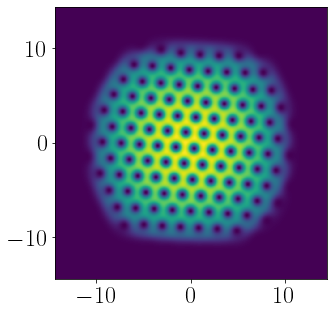

In [2]:
rc('text', usetex=True)
rc('font', family='serif',size='24')
# define arrays
#N = 400
#dx, dy = 0.05, 0.05
N = 1152
dx, dy = 0.025, 0.025
L = N*dx  # /2
x1 = np.linspace(-L/2, L/2, N)
y1 = np.linspace(-L/2, L/2, N)
x = x1[:, None] #reshape(x1, (N,1)) # np.array([x1]) # 
y = y1[:, None] #reshape(y1, (N,1)) # np.array([y1]) # 
X,Y = meshgrid(x1,y1)
#dx = x[1] - x[0]
#dy = y[1] - y[0]
kx1 = fft.fftfreq(N, dx)*2.0*pi
ky1 = fft.fftfreq(N, dy)*2.0*pi

kx = kx1[:,None] #reshape(kx1, (N,1)) # np.array([kx1]) #  
ky = ky1[:,None] #reshape(ky1, (N,1)) #  np.array([ky1]) # 
K = np.sqrt(kx**2 + (ky.T)**2)
K2 = K*K
K2_inv = 1.0/K2
K2 = np.nan_to_num(K2, nan=0, posinf=0, neginf=0)

# load data
#psi_r, psi_c = loadtxt('/Users/kishor/melting/draft/fig3/p7/fort.1',usecols=(0, 1), unpack='True')

psi_r, psi_c = loadtxt('/Users/kishor/melting/data/om_p99/spec/fort.1',  usecols=(0, 1), unpack='True')
psi = reshape(psi_r, (N, N)) + 1j*reshape(psi_c, (N, N))
#psi[psi==0]=1.0e-14+1j*1.0e-14
psi = transpose(psi)
psi2 = abs(psi)*abs(psi)
angle = np.arctan2(imag(psi), real(psi))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
pcolormesh(X, Y, transpose(psi2))
ax.set_aspect(1)

<ipython-input-4-f4df3f4da434>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(KX, KY, sqrt(sqrt(s1)), cmap='hot_r')


(-7.0, 7.0)

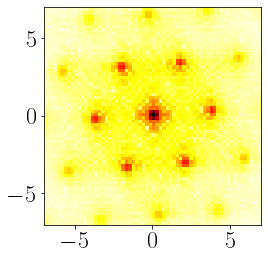

In [4]:
# structure factor
fd1 = fft.fft2(psi2); fds = fft.fftshift(fd1)
s1 = (abs(fds))
K1 = fft.fftshift(kx1)
K2 = fft.fftshift(ky1)
KX, KY = meshgrid(K1, K2)
fig, ax = plt.subplots()
plt.pcolormesh(KX, KY, sqrt(sqrt(s1)), cmap='hot_r')
ax.set_aspect(1)
xlim(-7, 7)
ylim(-7,7)

In [13]:
#masking the data -> w.r.t grid sizes of data
def mask1(h, w, c=None, rad=None):  #c-center
    if c is None: 
        c = (int(w/2), int(h/2))
    if rad is None:
        rad = min(c[0], c[1], w-c[0], h-c[1])
    y, x = np.ogrid[:h, :w]
    dis_cen = np.sqrt((x - c[0])**2 + (y-c[1])**2)
    mask = dis_cen <= rad
    return mask

def coarse_grain(psi, rad1, Omega, x, y, kx, ky, K2):
    vx, vy = velmod.velocity_lab(psi,Omega, x, y, kx, ky)
    wx = abs(psi)*vx
    wy = abs(psi)*vy
    Wi, Wc = velmod.helmholtz(wx, wy, kx, ky, K2) 
    wxi, wyi = Wi
    wxf = fft.fft2(wxi) #; swxf = fft.fftshift(wxf)
    wyf = fft.fft2(wyi) #; swyf = fft.fftshift(wyf)
    mask = 1*(hypot(kx,ky.T) < rad1)
    mx = mask*wxf
    my = mask*wyf
    '''h, w = swxf.shape[:2]; m1 = mask1(h, w, c=None, rad=rad1)
    mx = np.multiply(swxf,m1); my = np.multiply(swyf,m1)''' 
    iwx = fft.ifft2(mx)
    iwy = fft.ifft2(my)
    iw = hypot(abs(iwx),abs(iwy)) # real(iwx) + real(iwy) #
    wr = Omega*x - Omega*y.T
    rxy = hypot(x,y.T)
    abwr = abs(Omega*rxy)
    dx = (x[1,0]-x[0,0])
    dx = dy
    N = len(x)
    L = N*dx
    x1 = np.linspace(-L/2, L/2, N)
    y1 = np.linspace(-L/2, L/2, N)
    cg = wr*iw/abs(abwr)
    cg_omega = simps(simps(cg,x1),y1)
    return iwx, iwy, cg_omega

In [ ]:
def cg(psi, rad1, Omega, x, y, kx, ky, K2):
    vx, vy = velmod.velocity_lab(psi,Omega, x, y, kx, ky)
    wx = abs(psi)*vx
    wy = abs(psi)*vy
    wxf = fft.fft2(wx) #; swxf = fft.fftshift(wxf)
    wyf = fft.fft2(wy) #; swyf = fft.fftshift(wyf)
    mask = 1*(hypot(kx,ky.T) < rad1)
    mx = mask*wxf
    my = mask*wyf
    iwx = fft.ifft2(mx)
    iwy = fft.ifft2(my)
    iw = hypot(abs(iwx),abs(iwy)) # real(iwx) + real(iwy) #
    wr = Omega*x - Omega*y.T
    rxy = hypot(x,y.T)
    abwr = abs(Omega*rxy)
    dx = (x[1,0]-x[0,0])
    dx = dy
    N = len(x)
    L = N*dx
    x1 = np.linspace(-L/2, L/2, N)
    y1 = np.linspace(-L/2, L/2, N)
    cg = wr*iw/abs(abwr)
    cg_omega = simps(simps(cg,x1),y1)
    return iwx, iwy, cg_omega

-0.21828199419153455


(-14.0, 14.0)

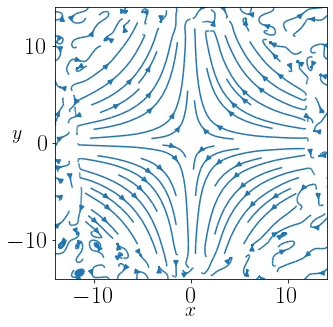

In [14]:
Omega = 0.99
kxi = 2*pi/(3*0.37)
iwx, iwy, cg_omega =  coarse_grain(psi,kxi,Omega, x,y,kx, ky, K2)
ei_c = abs(iwx)**2+abs(iwy)**2
print(cg_omega)
#plt.contour(x1, y1, ei_c )
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
#plt.pcolormesh(X, Y, (abs(iwx)**2+abs(iwy)**2))
plt.streamplot(x1, y1, real(iwx), real(iwy))
#plt.axis('equal')
#plot(x1, ei_c[:,600])
ax.set_aspect(1)
xlabel("$x$", labelpad=-5, fontsize=20)
ylabel("$y$", labelpad=-10,fontsize=20, rotation=360)
xlim(-14, 14)
ylim(-14,14)


(-12.0, 12.0)

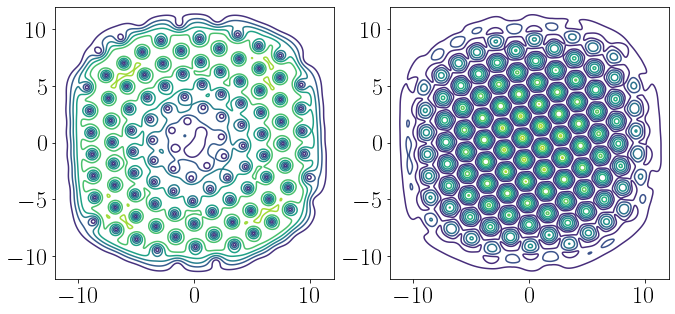

In [9]:
Omega = 0.99
vx, vy = velmod.velocity(psi, x, y, kx, ky)
vxr, vyr = velmod.velocity_rot(psi, Omega, x, y, kx, ky)
rho = abs(psi)*abs(psi)
wx = np.sqrt(rho)*vx
wy = np.sqrt(rho)*vy
wxr = np.sqrt(rho)*vxr
wyr = np.sqrt(rho)*vyr
Wi, Wc = velmod.helmholtz(wx, wy, kx, ky, K2) 
Wir, Wcr = velmod.helmholtz(wxr, wyr, kx, ky, K2) 
wxi, wyi = Wi
wxir, wyir = Wir

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
#ax[0].set_facecolor('white')
ax[0].contour(x1, y1, np.sqrt(abs(wx)**2+abs(wy)**2), cmap='viridis')
ax[0].set_xlim(-12, 12)    
ax[0].set_ylim(-12, 12)   
ax[1].contour(x1, y1, np.sqrt(abs(wxr)**2+abs(wyr)**2), cmap='viridis')
ax[1].set_facecolor("white")
ax[1].set_xlim(-12, 12)    
ax[1].set_ylim(-12, 12)  

In [10]:
def coarse(psi, wx, wy, rad1, Omega, x, y, kx, ky, K2):   
    wxf = fft.fft2(wx) #; swxf = fft.fftshift(wxf)
    wyf = fft.fft2(wy) #; swyf = fft.fftshift(wyf)
    mask = 1*(hypot(kx,ky.T) < rad1)
    mx = mask*wxf
    my = mask*wyf
    iwx = fft.ifft2(mx)
    iwy = fft.ifft2(my)
    iw = hypot(abs(iwx),abs(iwy))   
    wr = Omega*x - Omega*y.T
    rxy = hypot(x,y.T)
    abwr = abs(Omega*rxy)
    dx = (x[1,0]-x[0,0])
    dx = dy
    N = len(x)
    L = N*dx
    x1 = np.linspace(-L/2, L/2, N)
    y1 = np.linspace(-L/2, L/2, N)
    cg = wr*iw/abs(abwr)
    cg_omega = simps(simps(cg,x1),y1)
    return iw, cg_omega

In [12]:
'''Omega = 0.99
mu0 = 3.14
g = 500
mu_om = mu0*sqrt(1.0-Omega**2)
mu2 = 2.0*mu_om
V_eff = 0.5*((sqrt(x**2+y.T**2))**2)*(1.0-Omega**2)
n0_tf = (mu_om/g)*(1 - (V_eff/mu_om))

#print(shape(n0_tf))
print("$\mu_\Omega$=",mu_om)
n_1d = np.array(n0_tf[:,0]) 
plot(y1, n0_tf[:,1])
plot(x1, n0_tf[:,0])
#plot(x1, abs(psi[:,0])*2)
xlim(-10,10)
#ylim(0.002,.05)


vx, vy = velmod.velocity(psi,x, y, kx, ky)
V = np.sqrt(vx**2+vy**2)
V2 = V*V
#u2 = 1.0 - ((vx**2+vy**2)/mu2)
u2 = 1.0 - (V2/mu2)
 plt.streamplot(x1, y1, vx, vy, density=1)
plt.contour(x1, y1, u2)

n_tf = n0_tf*u2
n0 = n_tf[int(N/2),int(N/2)]
plt.contour(x1, y1, n_tf) '''

$\mu_\Omega$= 0.4429515097615091


'plt.contour(x1, y1, n_tf) '

In [21]:
Omega = 0.99
vx, vy = velmod.velocity_lab(psi,Omega, x, y, kx, ky)
wx = vx
wy = vy
wxf = fft.fft2(wx) ; swxf = fft.fftshift(wxf)
wyf = fft.fft2(wy) ; swyf = fft.fftshift(wyf)
kxi = 2*pi/(5*0.37)
# masking
mas = 1*(hypot(kx,ky.T) < kxi)
#ma = 1*mas
mx = wxf*mas
my = wyf*mas
iwx = fft.ifft2(mx)
iwy = fft.ifft2(my)
iw = np.sqrt(abs(iwx)**2+abs(iwy)**2) # real(iwx) + real(iwy) #


In [23]:
Omega = 0.99
wr = Omega*x - Omega*y.T
rxy = hypot(x,y.T)
abwr = Omega*rxy
cg = wr*iw/(abwr)
cg_omega = simps(simps(cg,x1),y1)
print(cg_omega)

-1096785.8380967772


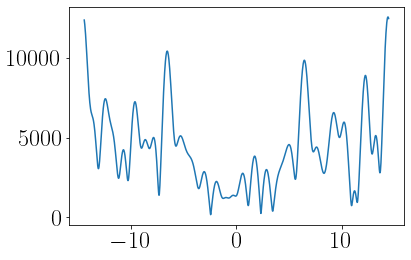

In [24]:
plot(x1, iw[:,600])
#plot(x1, psi2[:,100])

<ipython-input-16-70168a1680e9>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, w)


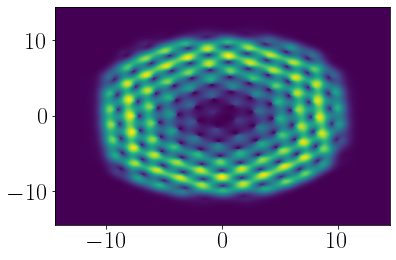

In [16]:
Omega = 0.99
vx, vy = velmod.velocity(psi, x, y, kx, ky)
rho = abs(psi)*abs(psi)
wx = np.sqrt(rho)*vx
wy = np.sqrt(rho)*vy
Wi, Wc = velmod.helmholtz(wx, wy, kx, ky, K2)
wxi, wyi = Wi
w = (abs(wxi)**2 + abs(wyi)**2)
plt.pcolormesh(X, Y, w)
#imshow(w, cmap='inferno')

(-14.0, 14.0)

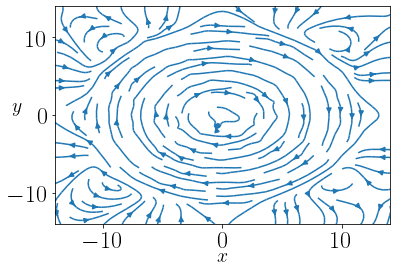

In [19]:
figsize=(5,5)
#f1 = plt.contourf(x1, y1, np.sqrt(wxi**2+wyi**2))
f1 = plt.streamplot(x1, y1, real(wxi), real(wyi))
#plt.axis('equal')
xlabel("$x$", labelpad=-5, fontsize=20)
ylabel("$y$", labelpad=-10,fontsize=20, rotation=360)
xlim(-14,14)
ylim(-14,14)
#plt.savefig('vi.png', dpi=400)

(1152, 1152)
8.055365778435366


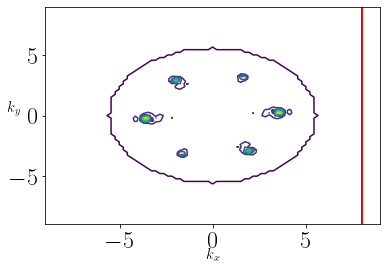

In [55]:
xi = 0.39
kxi = 2*np.pi/(2*xi)
# 
h, w = swxf.shape[:2]
m1 = mask1(h, w, c=None, rad=25)
mx = np.multiply(swxf,m1)
my = np.multiply(swyf,m1)
print(shape(mx))
plt.streamplot(kx1, ky1, real(mx), real(my))
plt.contour(kx1, ky1, sqrt(mx**2+my**2))
xlabel("$k_x$", labelpad=-5, fontsize=15)
ylabel("$k_y$", labelpad=-5,fontsize=15, rotation=360)
plt.axvline(2*pi/(2*xi), color='r', linestyle='-',linewidth=2.) 
#plt.axvline(-2*pi/(4*0.2), color='r', linestyle='-',linewidth=2.)#
xlim(-9,9)
ylim(-9,9)
#plt.savefig('vik_masked.png', dpi=400)
print(2*pi/(2*xi))

(-14.0, 14.0)

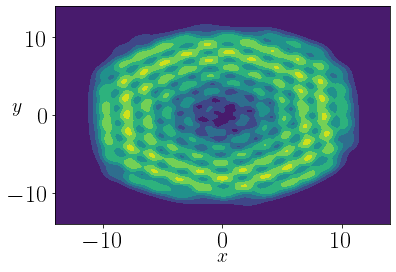

In [40]:
iwx = fft.ifft2(mx)
iwy = fft.ifft2(my)
plt.contourf(x1, y1,  np.sqrt(real(iwx)**2+real(iwy)**2))
#plt.streamplot(x1, y1, real(iwx), real(iwy))
#plt.axis('equal')
xlabel("$x$", labelpad=-5, fontsize=20)
ylabel("$y$", labelpad=-10,fontsize=20, rotation=360)
xlim(-14, 14)
ylim(-14,14)
#plt.savefig('vi_masked.png', dpi=400)

In [202]:
# try different masking
''' xn = np.linspace(-10, 10, 400)
yn = np.linspace(-10, 10, 400)
xn, yn = np.meshgrid(xn, yn)
x_0 = -3
y_0 = -5

acp = abs(psi)**2

def cmask(cp, N, radius):
    nx, ny = N, N
    center_x = nx // 2
    center_y = ny // 2
    ny, nx = cp.shape
    ix, iy = np.meshgrid(np.arange(nx), np.arange(ny))
    distance = np.sqrt((ix - center_x)**2 + (iy - center_y)**2)
    cp = np.ma.masked_where(distance > radius, cp)
    return cp
    # Plot
radius = 100   
cpm = cmask(acp, N, radius)   

imshow(cpm)

yn, xn = np.ogrid[:h, :w] 
c = (int(w/2), int(h/2))

print(min(c[0], c[1], w-c[0], h-c[1]))'''


In [76]:
vc = sqrt(real(iwx)**2+real(iwy)**2)
rig = Omega*x - Omega*y.T
rig_abs = Omega*(sqrt(x**2+y.T**2))
rigvc= rig*vc
Om_c = sum(rigvc)*dx*dy
print('Omega_c=', Om_c)

Omega_c= 1.0791646664804027


In [45]:
vc = sqrt(real(iwx)**2+real(iwy)**2)
rig_abs = (Omega*(sqrt(x**2+y.T**2)))**2
r_x = -Omega*y.T
r_y = Omega*x
vc_x = real(iwx)
vc_y = real(iwy)
rig_x = vc_x*r_x
rig_y = vc_y*r_y
Omc = np.sum(sqrt(rig_x**2+rig_y**2)/rig_abs)*dx*dy
print('Omega_c=', Omc)

Omega_c= 16.607552936947695
